In [1]:
import os
os.chdir('/Users/ngdnhtien/Research/Codespace/PulsatingPulseShop/')

# Necessary dependencies
import qiskit
import qiskit_ibm_provider

import utility as ut
import constant

import numpy as np
import pickle 
import matplotlib.pyplot as plt

plt.rcParams['axes.linewidth'] = 2.0
%config InlineBackend.figure_formats = ['svg']

# Backend specifications

Throughout these experiments we'll use the `ibm_brisbane` processor, focusing on `qubit = 0`.

In [2]:
provider = qiskit_ibm_provider.IBMProvider()
backend = provider.get_backend('ibm_brisbane')

backend_config = backend.configuration()
backend_defaults = backend.defaults()
backend_properties = backend.properties()
dt = backend_config.dt

qubit = 109
cbit = 0
num_qubits = int(qubit+1)
num_cbits = 1
weight = 1

In [3]:
rough_01_freq = backend_defaults.qubit_freq_est[qubit]
qubit_anharmonicty = backend_properties.qubits[qubit][3].value * constant.GHz
rough_12_freq = rough_01_freq + qubit_anharmonicty

print(r"f01 = "+f'{round(rough_01_freq/constant.GHz, 4)}'+' GHz')
print(r'f12 = '+f'{round(rough_12_freq/constant.GHz, 4)}'+' GHz')

f01 = 4.985 GHz
f12 = 4.6779 GHz


In [4]:
reset_circuit = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
reset_circuit.measure(qubit, cbit)

reset_circuits = [reset_circuit, reset_circuit]

# Sweeping duration

In [5]:
amp12_sweep_range = np.linspace(-0.75, 0.75, 100)

rabi12_gate = qiskit.circuit.Gate('Rabi Gate 32ns', weight, [])

rabi32_circs = []

for amp12 in amp12_sweep_range:
    
    with qiskit.pulse.build(backend=backend) as rabi12_sched:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        qiskit.pulse.play(qiskit.pulse.Drag(duration=80, amp=amp12, sigma=20, beta=0), drive_chan)
        
    rabi32_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
    rabi32_circ.x(qubit) # prepare state |1>
    rabi32_circ.append(rabi12_gate, [qubit]) # rabi oscillation with incremental amplitude
    rabi32_circ.measure(qubit, cbit)
    rabi32_circ.add_calibration(rabi12_gate, [qubit], rabi12_sched)

    rabi32_circs.append(rabi32_circ)

In [7]:
package = []

package = rabi32_circs + reset_circuits

rabi32_job = backend.run(package, meas_level=1, meas_return='avg', shots=2048)
rabi32_job.job_id()

In [8]:
# crkvhmygh8d0008ys23g 64+16
# crkvhyf82kmg008aep60 64+2*16
# crkvj2rakhw0008ex8m0 64+3*16

In [12]:
rabi32_job = provider.retrieve_job('crkvhmygh8d0008ys23g') # Lee Kwang Yew
rabi32_exp = ut.DataAnalysis(experiment=rabi32_job, average=True, shots=2048, qubit=0)
rabi32_exp.retrieve_data(average=True)

In [6]:
rabi32exp_IQdata = np.array(rabi32_exp.IQ_data) 

with open('./experiment/optimal_duration/data/96.pkl', 'wb') as f:
    pickle.dump(rabi32exp_IQdata, f)

# Fit

In [6]:
rabi32exp_IQdata = np.load('./experiment/optimal_duration/data/80.pkl', allow_pickle=True)
amp12_sweep_range = np.linspace(-0.75, 0.75, 100)

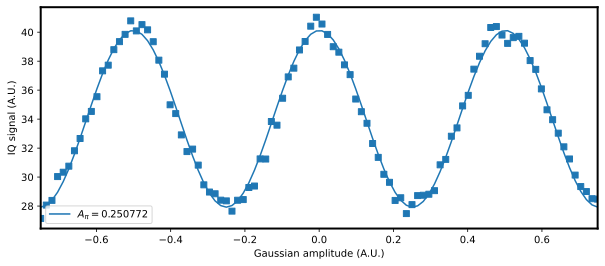

In [7]:
rabi32_exp_params, rabi32_exp_fit = ut.fit_function(
    amp12_sweep_range, rabi32exp_IQdata[:-2], lambda x, A, omega, phi, B: (A*np.cos(omega*x+phi)+B),
    [10, 2*np.pi/0.65, 0, 30]
)

fig, (ax) = plt.subplots(ncols=1, figsize=(10, 4))

# Experiment 1
ax.scatter(amp12_sweep_range, rabi32exp_IQdata[:-2], marker='s')
ax.plot(amp12_sweep_range, rabi32_exp_fit, label=r'$A_\pi=$'+f'{round(2*np.pi/rabi32_exp_params[1]/2, 6)}')

ax.set_xlabel('Gaussian amplitude (A.U.)')
ax.set_ylabel('IQ signal (A.U.)')
ax.set_xlim([min(amp12_sweep_range), max(amp12_sweep_range)])
ax.legend()
    
# fig.savefig('./phase1/data/logical/step1_calibrating_pi_pulse/two_rabi.png', dpi=300)

In [8]:
rabi_amp = round(2*np.pi/rabi32_exp_params[1]/2, 8)

amp_sx12 = 0.12538583
dur_sx12 = 80
sig_sx12 = 20
beta_sx12 = 0 

print(amp_sx12, dur_sx12, sig_sx12, beta_sx12)

0.12538583 80 20 0


In [9]:
def sched_01(phi, amp, beta):
    '''
        Generating a rotation in 01 with an angle phi away from the x-axis
    '''
    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_01_freq, drive_chan)
        with qiskit.pulse.phase_offset(phi, drive_chan):
            qiskit.pulse.play(qiskit.pulse.Drag(duration=120, amp=amp, sigma=30, beta=beta), drive_chan)
            
    return schedule

def sched_12(phi, amp, beta):
    '''
        Generating a rotation in 12 with an angle phi away from the x-axis
    '''
    with qiskit.pulse.build(backend=backend) as schedule:
        drive_chan = qiskit.pulse.drive_channel(qubit)
        qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
        with qiskit.pulse.phase_offset(phi, drive_chan):
            qiskit.pulse.play(qiskit.pulse.Drag(duration=dur_sx12, amp=amp_sx12, sigma=sig_sx12, beta=beta_sx12), drive_chan)
            
    return schedule

In [10]:
gate_sx12 = qiskit.circuit.Gate('SX12', weight, [])

ground_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
ground_circ.measure(qubit, cbit)

first_excited_state_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
first_excited_state_circ.x(qubit)
first_excited_state_circ.measure(qubit, cbit)

second_excited_state_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
second_excited_state_circ.x(qubit)
second_excited_state_circ.append(gate_sx12, [qubit])
second_excited_state_circ.append(gate_sx12, [qubit])
second_excited_state_circ.measure(qubit, cbit)
second_excited_state_circ.add_calibration(gate_sx12, [qubit], sched_12(0, amp_sx12, beta_sx12))

new_discrim = [ground_circ, first_excited_state_circ, second_excited_state_circ]

# APE + DRAG

In [11]:
reps = [5, 7, 9]

beta_sweep_vals = np.linspace(-2.0, 1.0, 100)

ape_withY_circs = []

for rep in reps:
    for beta_sweep in beta_sweep_vals:
        apeY_circ = qiskit.circuit.QuantumCircuit(num_qubits, num_cbits)
        apeY_circ.x(qubit)
        
        with qiskit.pulse.build(backend=backend) as rough_hp12_sched:
            drive_chan = qiskit.pulse.drive_channel(qubit)
            qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
            qiskit.pulse.play(qiskit.pulse.Drag(duration=dur_sx12, amp=amp_sx12, sigma=sig_sx12, beta=beta_sweep), drive_chan)
        rough_hp12_gate = qiskit.circuit.Gate('rough_hp12_gate', weight, []) 

        apeY_circ.append(rough_hp12_gate, [qubit])
        
        with qiskit.pulse.build(backend=backend) as pseudoYcorrect_sched:
            drive_chan = qiskit.pulse.drive_channel(qubit)
            qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
            qiskit.pulse.play(qiskit.pulse.Drag(duration=dur_sx12, amp=amp_sx12, sigma=sig_sx12, beta=beta_sweep), drive_chan)
            qiskit.pulse.play(qiskit.pulse.Drag(duration=dur_sx12, amp=-amp_sx12, sigma=sig_sx12, beta=beta_sweep), drive_chan)
        pseudoYcorrect_gate = qiskit.circuit.Gate('pseudo_gate', weight, [])
        
        with qiskit.pulse.build(backend=backend) as axial_hp_sched:
            drive_chan = qiskit.pulse.drive_channel(qubit)
            qiskit.pulse.set_frequency(rough_12_freq, drive_chan)
            qiskit.pulse.play(qiskit.pulse.Drag(duration=dur_sx12, amp=-amp_sx12, sigma=sig_sx12, beta=beta_sweep), drive_chan)
        axial_hp_gate = qiskit.circuit.Gate('axial_hp_gate', weight, [])
        
        for j in range(rep):
            apeY_circ.append(pseudoYcorrect_gate, [qubit])
            
        apeY_circ.append(axial_hp_gate, [qubit])
        apeY_circ.measure(qubit, cbit)
        apeY_circ.add_calibration(rough_hp12_gate, [qubit], rough_hp12_sched)
        apeY_circ.add_calibration(pseudoYcorrect_gate, [qubit], pseudoYcorrect_sched)
        apeY_circ.add_calibration(axial_hp_gate, [qubit], axial_hp_sched)
        
        ape_withY_circs.append(apeY_circ)

In [16]:
apeY_package = []
apeY_package = new_discrim + ape_withY_circs + reset_circuits

apeY_job = backend.run(apeY_package, meas_level=1, meas_return='single', shots=2048)

apeY_job.job_id()

'crmwvmek8vm00086qyk0'

In [12]:
apeY_job = provider.backend.retrieve_job('crmwvmek8vm00086qyk0')
apeY_data = ut.DataAnalysis(experiment=apeY_job, average=False, shots=2048, qubit=0)
apeY_data.retrieve_data(average=False)
apeY_data.build_discrim()
apeY_data.count_pop()
apeY_data.error_mitiq()

In [13]:
apeY_data_pop1 = apeY_data.mitiq_data[3:-2, 1]
apeY_data_pop2 = apeY_data.mitiq_data[3:-2, 2]
apeY_data_pop1_raw = np.array(apeY_data.raw_counted)[3:-2, 1]
apeY_data_pop2_raw = np.array(apeY_data.raw_counted)[3:-2, 2]

In [14]:
with open('./experiment/optimal_duration/data/80_ape_drag_pop1.pkl', 'wb') as f:
    pickle.dump(apeY_data_pop1_raw, f)
    
with open('./experiment/optimal_duration/data/80_ape_drag_pop2.pkl', 'wb') as f:
    pickle.dump(apeY_data_pop2_raw, f)

# Fit

In [15]:
apeY_data_pop2 = np.load('./experiment/optimal_duration/data/80_ape_drag_pop2.pkl', allow_pickle=True)

In [25]:
apeYcorrection_pop2 = []

beta_sweep_vals = np.linspace(-2.0, 1.0, 100)
length = len(beta_sweep_vals)

for j in range(3):
    apeYcorrection_pop2.append(apeY_data_pop2[j*length:(j+1)*length])

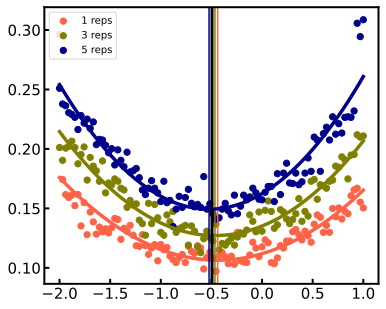

In [29]:
fig, ax = plt.subplots(ncols=1, figsize=(6, 5))
color_pallete = ['tomato', 'olive', 'darkblue', 'orchid', 'coral', 'yellowgreen']

beta_corrections = []

for idx, pop in enumerate(apeYcorrection_pop2):
    color = color_pallete[idx]
    beta_swept = beta_sweep_vals
    population_2 = pop
    
    ax.scatter(beta_swept, population_2, s=40, marker='o', color=color, label=f'{2*idx+1}'+' reps')
    
    param, yfit = ut.fit_function(beta_swept, population_2, 
                              lambda x, A, B, x0: (A*(x-x0)**2+B),
                              [10, 0.1, 2])
    beta_corrections.append(param[2])
    
    ax.plot(beta_swept, yfit, linewidth=3.5, color=color)
    ax.axvline(param[2], color=color)
    
# ax.set_xlim([min(beta_sweep_vals), max(beta_sweep_vals)])
# ax.set_ylim([-0.03, 0.3])
ax.legend()
ax.tick_params(axis='both', direction='in', which='both', labelsize=15)
ax.tick_params(axis='both', which='major', length=5, width=2.0)
ax.axvline(sum(beta_corrections[1:])/len(beta_corrections[1:]), linewidth=3.0, color='black')